In [1]:
# are the future functions actually necessary?
from __future__ import absolute_import, division, print_function, unicode_literals
import imp

from data_read import read_paths
from pathData import PathData
from snapData import SnapData
from datasetData import DatasetData
from plotData import PlotData
from importanceData import ImportanceData
from globalConstants import Const
from autoEncoder import AutoEncoder 
from stepwiseData import StepwiseData
#from data_plot import map_generated

import numpy as np
import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=3, suppress=True)
# allows for automatic reloading of imports and makes it unncessecary to restart the kernel
# whenever a function is changed
%load_ext autoreload
%autoreload 2

In [2]:
#setter c.used_vars
bce = tf.keras.losses.BinaryCrossentropy()
bce = tf.keras.losses.CategoricalCrossentropy()
bce = tf.keras.losses.CategoricalHinge()
loss = bce([1.], [0.])
#print('Loss: ', loss.numpy())  # Loss: 11.522857
def neg_likelihood(y_actual, y_pred):
#    return -(y_actual*math.log(y_pred) + (1-y_actual)*math.log(1-y_pred))
    #print(y_actual*math.log(y_pred), (1-y_actual)*math.log(1-y_pred))
    # tf.math.log()
    return -(y_actual * tf.math.log(y_pred) + (1-y_actual) * tf.math.log(1-y_pred))
#print(likelihood_max_loss(1., 0.9999))
loss = neg_likelihood(tf.constant([1.,1.]), tf.constant([0.000000000001,0.9]))
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  [27.631  0.105]


In [3]:
c = Const()
used_vars = [0, 1, 7, 8, 9]
#used_vars = [0, 1, 7, 8, 9, 10, 11, 13, 3]
#used_vars = [0, 2, 5, 6, 7, 8, 9, 11, 13, 17, 18, 19, 20, 21]
#used_vars = [
#    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
#    12, 13, 14, 15, 16, 17, 18, 19, 20, 21
#    ]
var_names = c.used_names(used_vars)
var_order = c.used_order(used_vars)
print(var_names)


{0: 'MCG', 1: 'N_{w,4}', 2: 'R_g', 3: '5^{12}6^{2}', 4: '5^{12}'}


In [6]:
pathO = PathData(
    *read_paths(
        c.folder_name, 
        c.mcg_A, 
        c.mcg_B,
        used_vars,
        0.1), 
    c.path_type_labels, 
    c.path_type_weights)

mcg100
Total paths: 552	 Used paths: 55
mcg30
Total paths: 2776	 Used paths: 277
mcg90
Total paths: 292	 Used paths: 29
Sum weights: 361.0000000000003
Mean weights: 1.0


In [7]:
snapO = SnapData(
    *pathO.snapshots_labels_weights(
        offset = c.offset, 
        progress = c.progress, 
        transitioned = c.transitioned, 
        turnedback = c.turnedback))

Mean weights: 0.27052335798662935
Sum weights AA: 50228.61292169616	 Sum weights AB: 2.360598389662972e-06
Sum weights AA after: 50228.61292169616	 Sum weights AB after: 2.360598389662972e-06


In [8]:
dataO = DatasetData(
    *snapO.split_lists(c.train_ratio, c.val_ratio), 
    outlier_cutoff = c.outlier_cutoff)

In [9]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
train_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.train_norm_past_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: dataO.train_norm_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_weights, 
    c.output_name_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")


Get normed
Get bounded
Get mean, std and inv_std
Got bounded
train_ds generated
val_ds generated


In [10]:

modelO = AutoEncoder(c)
(autoencoder, autoencoder_1, autoencoder_2) = \
    modelO.model(dataO.dimensions)

In [11]:
stepO = StepwiseData(*dataO.stepwise_data())

In [13]:
stepO.get_score( 
    [0,1,2], 
    1, 
    1, 
    c)

 Repetition 1


3.306599e-08

In [16]:
used, loss = stepO.bottom_up(
    [], 
    [0,1,2], 
    3, 
    2, 
    3, 
    c)

[0]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.13949052432069073
[1]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.13494322982927162
[2]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.13275764805299264
[2, 0]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.12721557025970132
[2, 1]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.13362709893672556
[2, 0, 1]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.12986963614821434

 [2, 0, 0] 0.12986963614821434


In [22]:
used, loss = stepO.top_down( 
    used_vars,
    [],
    3, 
    2, 
    3, 
    c)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.2138358617270434
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.21395271988930528
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.21360791982324034
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.21500931776784085
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.21225320776855505
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.21487091782468337
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 Repetition 1
 Repe

  Mean loss: 0.20189634591892913
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1977255584189185
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.19758563783985597
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.20090368058946398
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.19219450923027817
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.19401505266626676
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.18839208124964327
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
 Repetition 1
 Repetition 2
 Repetition 3


 Repetition 2
 Repetition 3
  Mean loss: 0.165299680415127
[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.16381523283543412
[1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.16411955527685304
[0, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1664993852238964
[0, 1, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.16969457243879638
[0, 1, 2, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1665124479819227
[0, 1, 2, 3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.16832084891696772
[0, 1, 2, 3, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1629030353769108
[0, 1, 2, 3, 4, 5, 9, 11, 12, 13, 14, 

 Repetition 2
 Repetition 3
  Mean loss: 0.1415521996440711
[0, 1, 2, 3, 4, 5, 8, 9, 11, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.14842458629497776
[0, 1, 2, 3, 4, 5, 8, 9, 11, 14, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.14294701923650724
[0, 1, 2, 3, 4, 5, 8, 9, 11, 14, 15]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1458331952078475
[1, 2, 3, 4, 5, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.14120189958700427
[0, 2, 3, 4, 5, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1416226182270933
[0, 1, 3, 4, 5, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1395846967757852
[0, 1, 2, 4, 5, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.14601663494551623
[0, 1, 2, 3, 5, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.1402197919510029
[0, 1, 2, 3, 4, 8, 9, 14, 15, 16]
 Repetition 1
 Repetition 2
 

In [55]:
print(used, loss)

[15, 13] 9.373772518226107e-11


In [14]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)

history = autoencoder.fit(
    train_ds,epochs = c.epochs, 
    validation_data = val_ds)

Train for 1741 steps, validate for 291 steps
Epoch 1/5
1741/1741 [==============================] - 7s 4ms/step - loss: 0.0943 - label_loss: 0.0055 - reconstruction_loss: 0.0888 - val_loss: 0.1310 - val_label_loss: 1.6660e-08 - val_reconstruction_loss: 0.1310
Epoch 2/5
1741/1741 [==============================] - 4s 3ms/step - loss: 0.0872 - label_loss: 6.4652e-09 - reconstruction_loss: 0.0872 - val_loss: 0.0868 - val_label_loss: 2.3012e-10 - val_reconstruction_loss: 0.0868
Epoch 3/5
1741/1741 [==============================] - 5s 3ms/step - loss: 0.0585 - label_loss: 2.3309e-10 - reconstruction_loss: 0.0585 - val_loss: 0.0567 - val_label_loss: 2.3781e-10 - val_reconstruction_loss: 0.0567
Epoch 4/5
1741/1741 [==============================] - 5s 3ms/step - loss: 0.0554 - label_loss: 2.3913e-10 - reconstruction_loss: 0.0554 - val_loss: 0.0557 - val_label_loss: 2.4262e-10 - val_reconstruction_loss: 0.0557
Epoch 5/5
1741/1741 [==============================] - 5s 3ms/step - loss: 0.0552 -

In [15]:
print(history.history["val_loss"][-1])

0.056219329046168685


In [16]:
plotO = PlotData(*dataO.plot_data(), c.stamp)

1: N_{w,4}	0: MCG
2: 5^{12}	0: MCG
2: 5^{12}	1: N_{w,4}
3: 5^{12}6^{2}	0: MCG
3: 5^{12}6^{2}	1: N_{w,4}
3: 5^{12}6^{2}	2: 5^{12}
4: R_g	0: MCG
4: R_g	1: N_{w,4}
4: R_g	2: 5^{12}
4: R_g	3: 5^{12}6^{2}
0


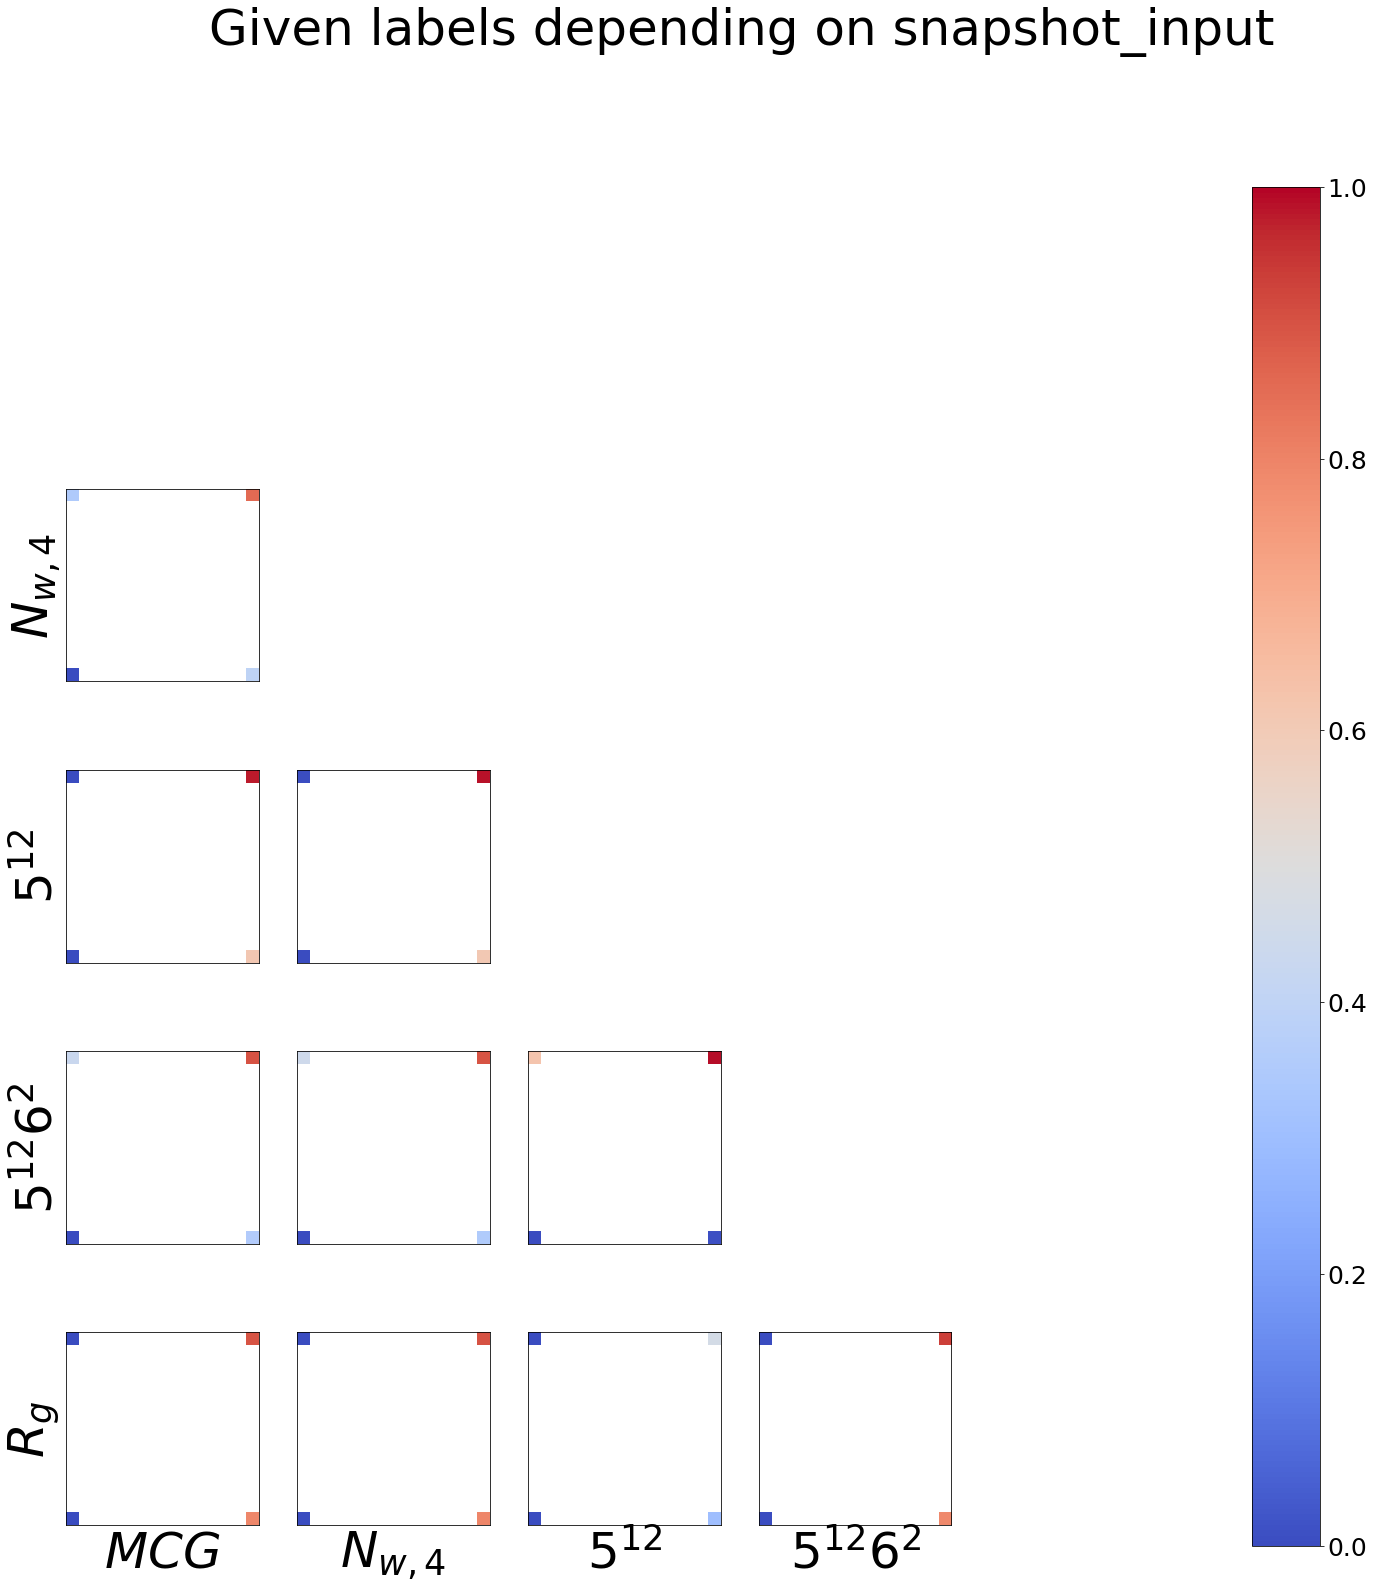

In [17]:

plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
#    resolution = c.resolution, 
    resolution = 15,
    vmin = c.min_label, vmax = c.max_label, model = None, fill_val = 0)
        

pass

1: N_{w,4}	0: MCG
2: 5^{12}	0: MCG
2: 5^{12}	1: N_{w,4}
3: 5^{12}6^{2}	0: MCG
3: 5^{12}6^{2}	1: N_{w,4}
3: 5^{12}6^{2}	2: 5^{12}
4: R_g	0: MCG
4: R_g	1: N_{w,4}
4: R_g	2: 5^{12}
4: R_g	3: 5^{12}6^{2}
0


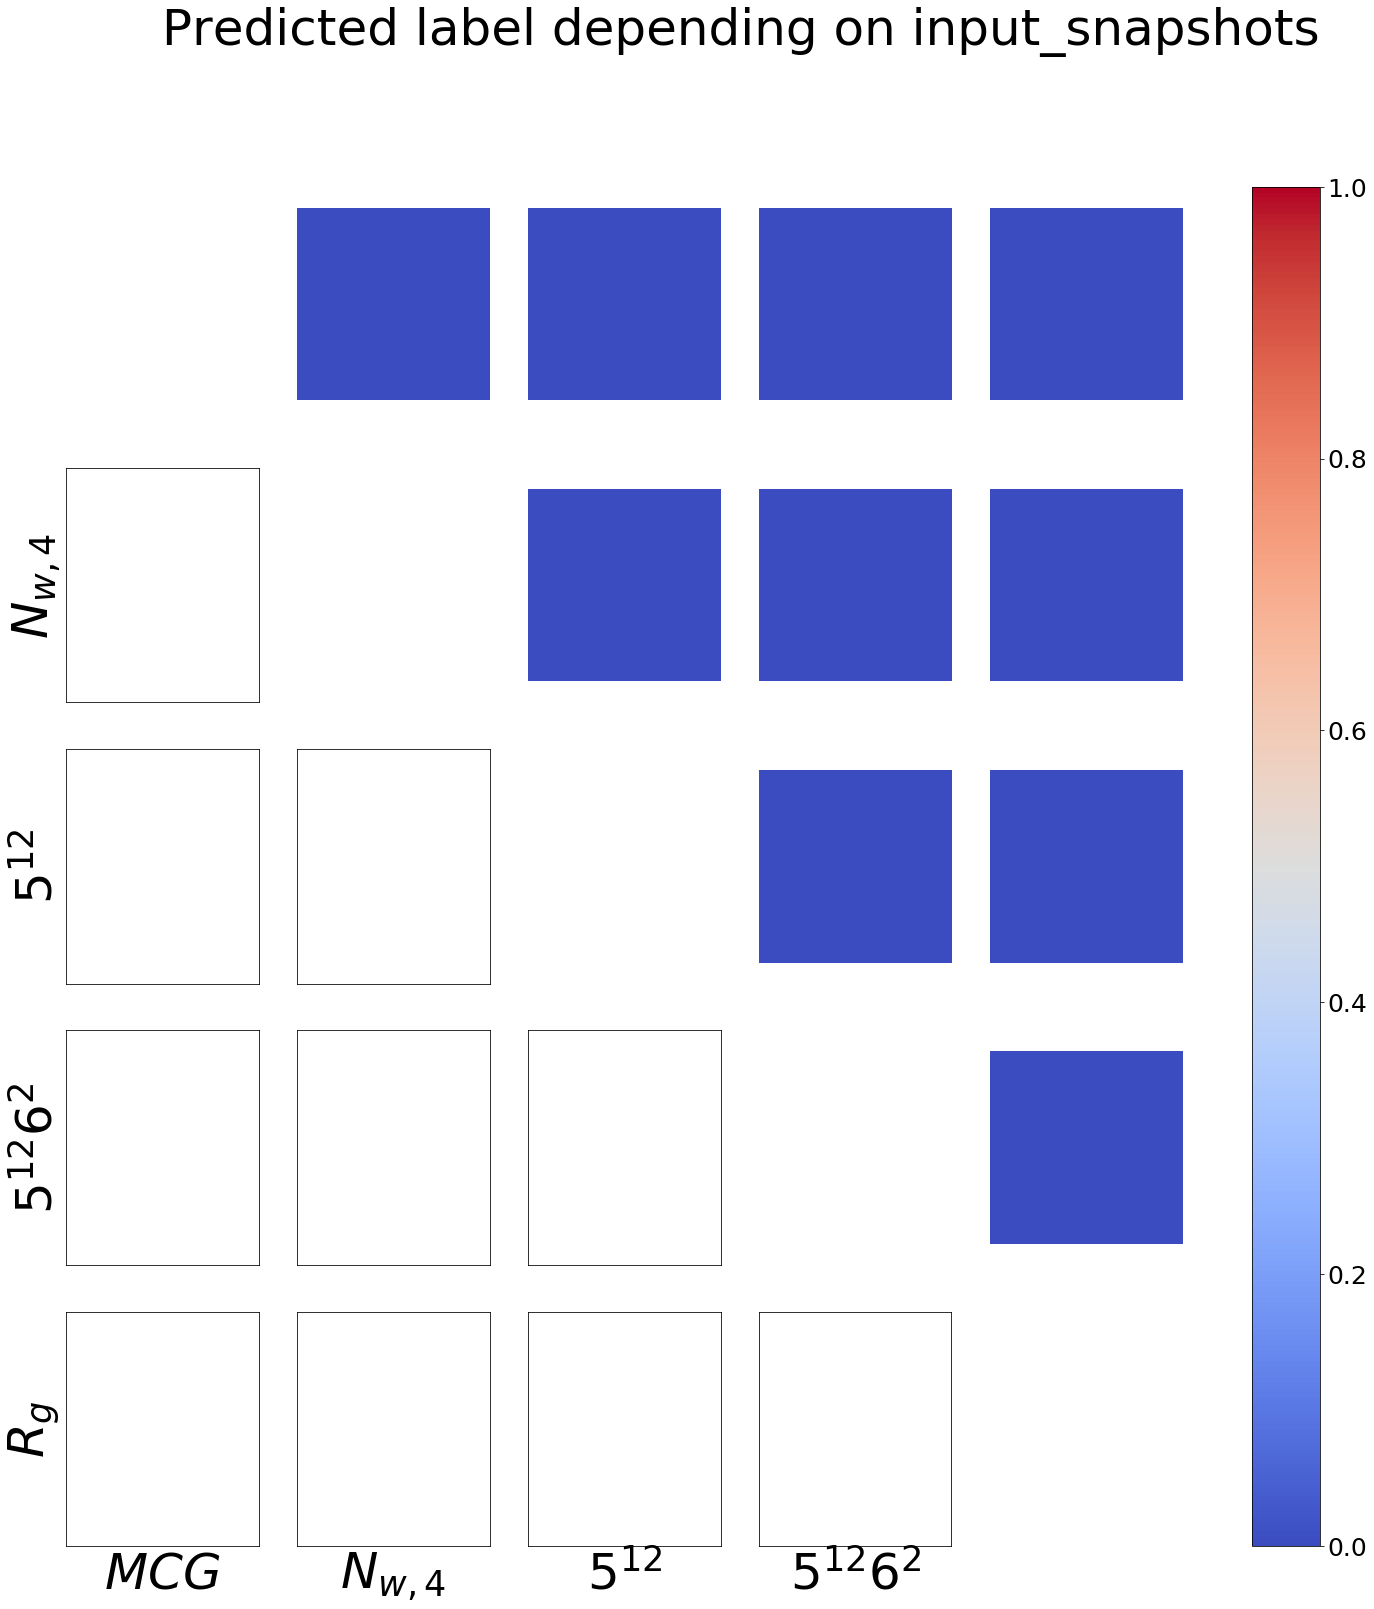

In [16]:
plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, 
    vmin = c.min_label, vmax = c.max_label, 
    model = autoencoder_1, fill_val = 0)
pass

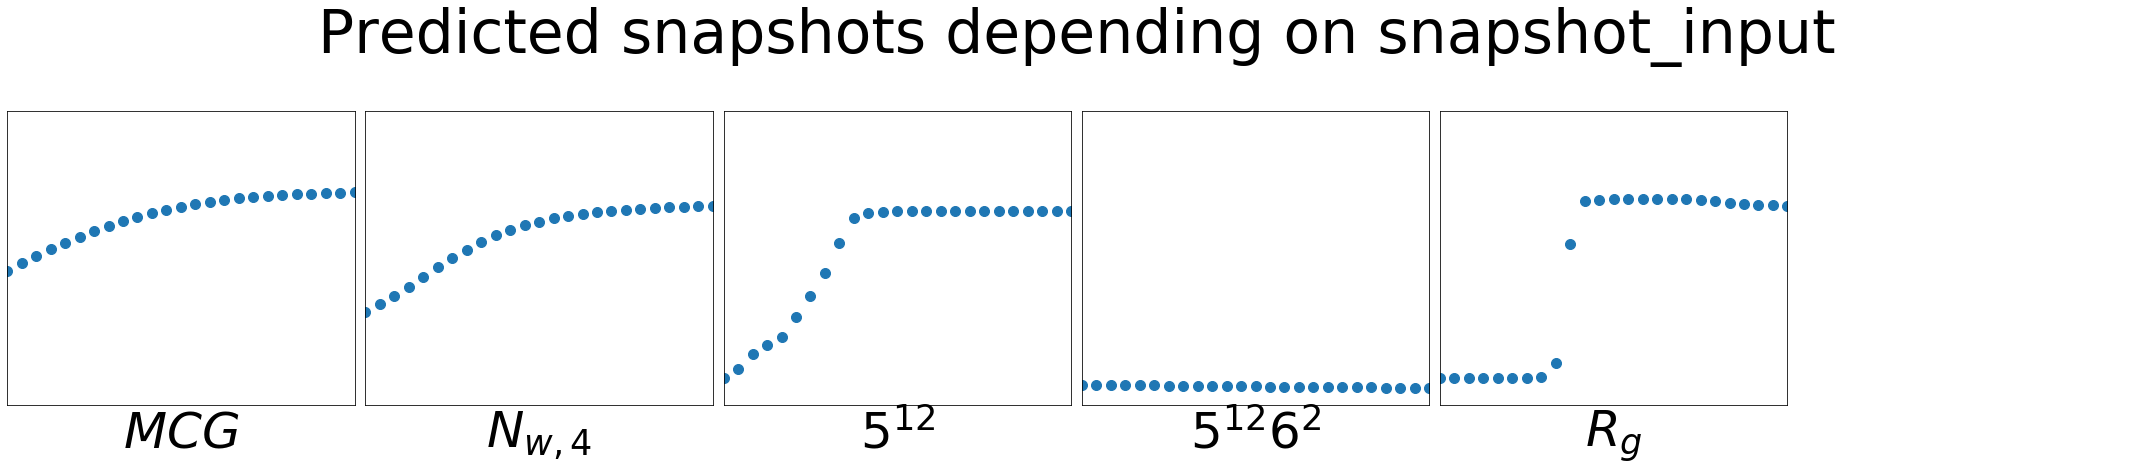

In [17]:
plotO.plot_super_scatter(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, model = autoencoder_2, 
    max_row_len = 6, fill_val = 0)

In [15]:
impO = ImportanceData(
    *dataO.importance_data(),
    c.corr_thresholds)

impO.measure_correlation()
pass

Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.5 were found between 41 pair(s) of input variables:
	1,0: 1.009
	2,0: 0.997
	2,1: 0.991
	4,0: 0.575
	4,1: 0.571
	4,2: 0.564
	5,0: 0.979
	5,1: 0.984
	5,2: 0.965
	5,4: 0.573
	6,0: 0.977
	6,1: 0.978
	6,2: 0.962
	6,4: 0.530
	6,5: 0.924
	7,0: 0.813
	7,1: 0.799
	7,2: 0.812
	7,5: 0.762
	7,6: 0.767
	8,0: 1.008
	8,1: 1.008
	8,2: 0.994
	8,4: 0.572
	8,5: 0.980
	8,6: 0.978
	8,7: 0.776
	9,0: 0.824
	9,1: 0.826
	9,2: 0.817
	9,5: 0.746
	9,6: 0.846
	9,7: 0.637
	9,8: 0.826
	10,6: 0.516
	11,0: 0.545
	11,1: 0.546
	11,2: 0.536
	11,5: 0.518
	11,6: 0.508
	11,8: 0.543
Additionally, weak correlations of more than 0.1 were found between 37 pair(s) of input variables:
	7,4: 0.486
	9,4: 0.407
	10,0: 0.439
	10,1: 0.438
	10,2: 0.437
	10,4: 0.156
	10,5: 0.340
	10,7: 0.333
	10,8: 0.441
	10,9: 0.415
	11,4: 0.318
	11,7: 0.453
	11,9: 0.462
	11,10: 0.225
	12,0: 0.391
	12,1: 0.393
	12,2: 0.387
	

val_ds generated
Mode: Mean
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: HIPR
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: Shuffle
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturb

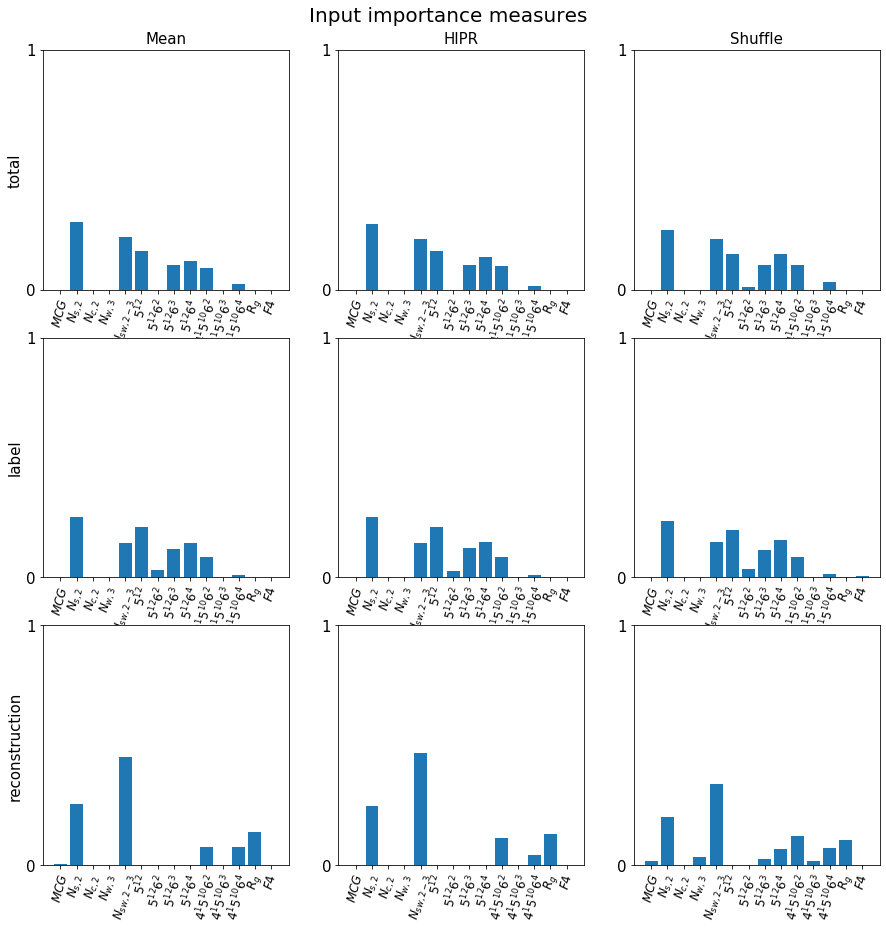

In [16]:
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

modes = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
#modes = [["Perturb", 0.5]]

impO.plot_super_importance(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    repetitions = 1, modes = modes,
    loss_names = c.loss_names,
    val_ds = val_ds, model = autoencoder)


In [17]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.test_norm_past_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_labels, 
    c.output_name_2: dataO.test_norm_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_weights, 
    c.output_name_2: dataO.test_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("test_ds generated")

test_ds generated


In [14]:
impO.reduced_set_importance([1], [2,3,4,5,6], "a", 1)

('will be set later', 'will be set later')

In [25]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
t = np.transpose(a)
print(t)
n = []
for i in [0,2]:
    n.append(t[i])

print(np.transpose(n))
print(np.transpose([t[0],t[2]]))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]
[[1 3]
 [4 6]
 [7 9]]
[[1 3]
 [4 6]
 [7 9]]


In [79]:
print(c.stamp)
print(c.reconstruction_loss_weight)
c.loss_weights = [3,4]
print(c.loss_weights)
print(c.reconstruction_loss_weight)
print(c.stamp)

trT_reT_pT_o0_oc0.05_bn2_4*(4None+4tanh|4tanh)_pw1:10:0:0_lw1:1_e2
1
[3, 4]
4
trT_reT_pT_o0_oc0.05_bn2_4*(4None+4tanh|4tanh)_pw1:10:0:0_lw3:4_e2


In [ ]:
#VAR_NAMES = {i:ALL_VAR_NAMES[i] for i in USED_VARS}
#VAR_ORDER = [i for i in ALL_VAR_ORDER if i in USED_VARS]
#VAR_ORDER = [i for i in range(len(ALL_VAR_ORDER)) if ALL_VAR_ORDER[i] in USED_VARS]


In [ ]:
"""
VAR_NAMES = {
    0: "MCG",
    11: "N_{s,2}",
    12:"N_{s,3}",    
    15: "N_{s,4}",
    13: "N_{c,2}",
    14: "N_{c,3}",
    16: "N_{c,4}",
    3: "N_{w,2}",   
    2: "N_{w,3}",
    1: "N_{w,4}",
    5: "N_{sw,2-3}",    
    4: "N_{sw,3-4}",
    9: "5^{12}",
    8: "5^{12}6^{2}",
    17: "5^{12}6^{3}",
    18: "5^{12}6^{4}",
    19: "4^{1}5^{10}6^{2}",
    20: "4^{1}5^{10}6^{3}",
    21: "4^{1}5^{10}6^{4}",
    10: "CR",
    7: "R_g",
    6: "F4"
    }"""

"""
VAR_NAMES = {
    0: "MCG"
    1: "N_{s,2}"
    2 :"N_{s,3}"
    3: "N_{s,4}"
    4: "N_{c,2}"
    5: "N_{c,3}"
    6: "N_{c,4}"
    7: "N_{w,2}"
    8: "N_{w,3}"
    9: "N_{w,4}"
    10: "N_{sw,2-3}"
    11: "N_{sw,3-4}"
    12: "5^{12}"
    13: "5^{12}6^{2}"
    14: "5^{12}6^{3}"
    15: "5^{12}6^{4}"
    16: "4^{1}5^{10}6^{2}"
    17: "4^{1}5^{10}6^{3}"
    18: "4^{1}5^{10}6^{4}"
    19: "CR"
    20: "R_g"
    21: "F4"
    }"""
pass

In [17]:
model = autoencoder
print(model.name)
print(model.input_names)
print(model.output_names)

Autoencoder
['input_snapshots']
['label', 'reconstruction']


In [11]:
def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
#past, present = data.offset_path_lists(5)
#print(past[0][:10])
#print(present[0][:5])
#print(data.path_list[0])
#print(data.label_list[2])
#print(data.mc_weight_list[2])
#AA_past_snapshot_list, AB_past_snapshot_list, \
#    BA_past_snapshot_list, BB_past_snapshot_list, \
#    AA_snapshot_list, AB_snapshot_list, \
#    BA_snapshot_list, BB_snapshot_list, \
#    AA_snapshot_label_list, AB_snapshot_label_list, \
#    BA_snapshot_label_list, BB_snapshot_label_list, \
#    AA_snapshot_weight_list, AB_snapshot_weight_list, \
#    BA_snapshot_weight_list, BB_snapshot_weight_list = paths.snapshot_label_weight_lists(0,True,True,True)